<a href="https://colab.research.google.com/github/pedrotorres08/DadosSetorEletrico/blob/main/DadosAbertosANEEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1- Introdução**

**Leitura da base de dados abertos da ANEEL**
<br>
-Acesso via link: https://dadosabertos.aneel.gov.br/dataset/
<br>
-Os dados podem ser acessados via API do CKAN, e estão estruturados em formato JSON
<br><br>
Serão aplicados dois datasets como exemplo: (1) Valores de TUSD e TE aplicados por cada distribuidora e (2)Detalhamento das interrupções de distribuição para um distribuidora específica.<br>
Primeiramente, vamos fazer a leitura dos valores de TUSD e TE homologados para cada distribudora, que podem ser obtidos na seguinte página:
<br>
https://dadosabertos.aneel.gov.br/dataset/tarifas-distribuidoras-energia-eletrica
<br>
e clicando-se no link para o arquivo .csv

Para fazer a leitura dos dados via API, primeiramente é preciso identificar a 
ID do dataset a ser lido, que pode ser visualizada no endereço da página:
<br><br>
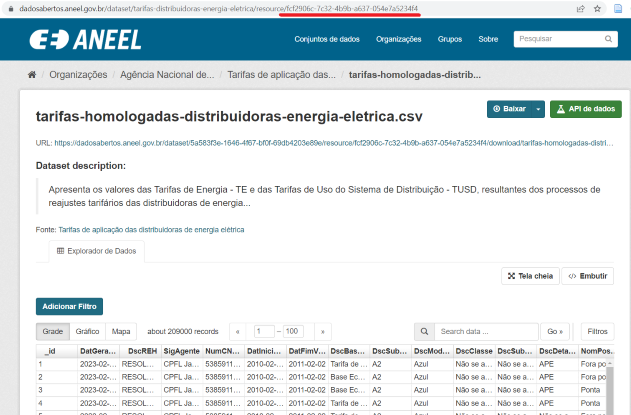

**2 - Implementação em Python**


Para fazer a leitura, utilizaremos uma request a API do CKAN e filtraremos apenas as tarifas mais recentes aplicadas ao subgrupo B1, convencional, residencial de cada distribuidora:

In [170]:
import pandas as pd
import requests

In [171]:
#url para acesso ao portal de dados abertos da ANEEL
url_base = 'https://dadosabertos.aneel.gov.br/api/3/action/datastore_search?'

rid = 'fcf2906c-7c32-4b9b-a637-054e7a5234f4' #ID Tarifas
DscSubGrupo = 'B1'
DscModalidadeTarifaria = 'Convencional'
DscSubClasse = 'Residencial'
DscBaseTarifaria = 'Tarifa de Aplicação'

limite = 32000 #Limite padrao de leituras em uma unica request do CKAN
fields = 'VlrTUSD,VlrTE,SigAgente,DatFimVigencia'
filters = {"DscSubGrupo": DscSubGrupo, "DscModalidadeTarifaria": DscModalidadeTarifaria,
           "DscSubClasse": DscSubClasse, "DscBaseTarifaria": DscBaseTarifaria}

#Ler apenas a primeira linha do dataset e determinar o numero total de linhas (n_max)
r = requests.post(url_base, json={"resource_id": rid, "limit": "1", "offset": "0", "fields": fields, "filters": filters})
df_res = pd.DataFrame(r.json()['result']['records'])
n_max = r.json()['result']['total']
print("Número total de entradas: {}".format(n_max))

#Agora, fazer a leitura dos demais dados (da segunda linha até n_max)
for offset in range(1,n_max,limite):
  print("Leitura do dataset... {:.2f} %".format(offset/n_max*100))
  r = requests.post(url_base, json={"resource_id": rid, "limit": "{}".format(limite), "offset": "{}".format(offset), "fields": fields, "filters": filters})
  df_res = pd.concat([df_res, pd.DataFrame(r.json()['result']['records'])], ignore_index=True)

#Substituir , por . nas colunas com valores numéricos 
df_res['VlrTUSD'] = df_res['VlrTUSD'].replace(',','.',regex=True)
df_res['VlrTE'] = df_res['VlrTE'].replace(',','.',regex=True)

#Converter o tipo de dados para float
df_res['VlrTUSD'] = df_res['VlrTUSD'].astype(float)
df_res['VlrTE'] = df_res['VlrTE'].astype(float)

#Filtrar apenas as tarifas mais recentes
df_filt = df_res.sort_values('DatFimVigencia').groupby('SigAgente').last()
df_filt = df_filt[['VlrTUSD', 'VlrTE']].reset_index(level=0)

Número total de entradas: 1607
Leitura do dataset... 0.06 %


Text(0, 0.5, 'TUSD [R$/MWh], TE [R$/MWh]')

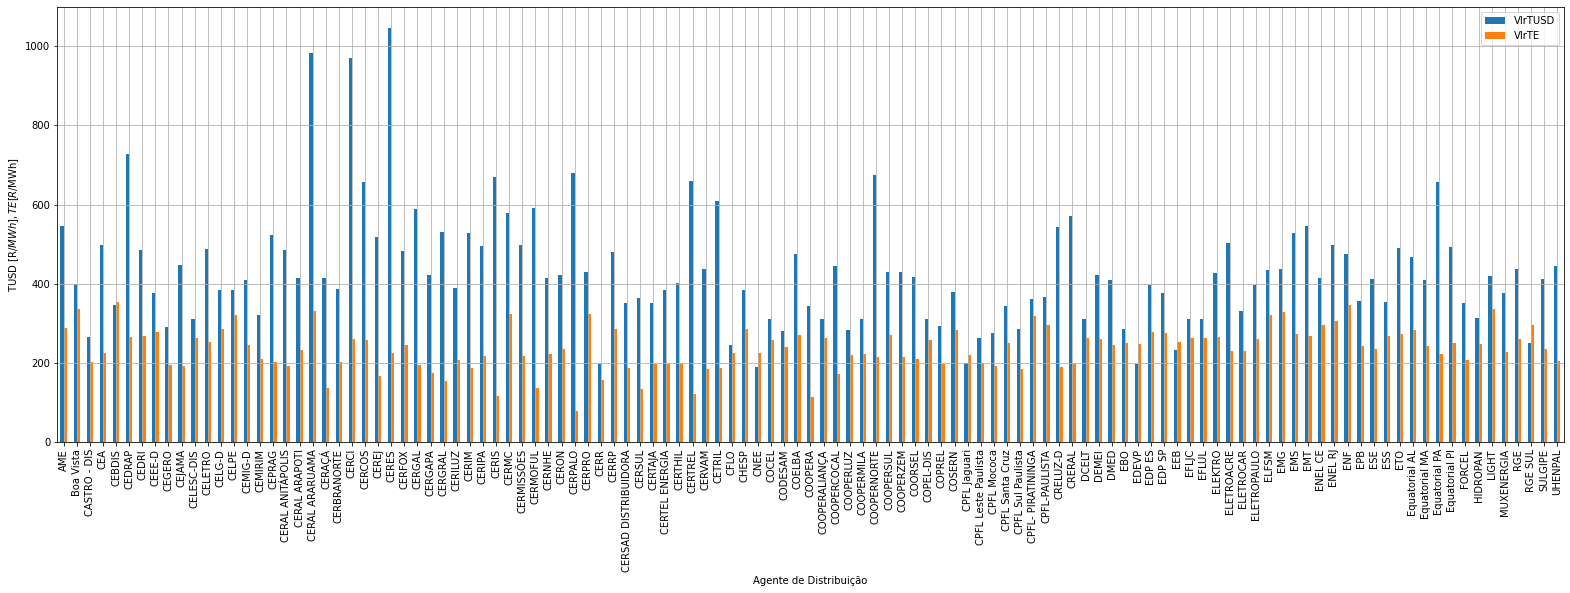

In [172]:
#Plotar as tarifas
ax = df_filt.plot(x="SigAgente", y=["VlrTUSD", "VlrTE"], kind="bar", figsize=(27, 8), grid=True)
ax.set_xlabel("Agente de Distribuição")
ax.set_ylabel("TUSD [R$/MWh], TE [R$/MWh]")

**3 - Interrupções de Energia Elétrica - 2019**


Neste segundo exemplo, faremos a leitura de outro dataset: interrupções de energia nas redes de distribuição.
Será aplicado um filtro de CNPJ do agente de distribuição, para baixar apenas os dados relativos à Equatorial-PA, no ano de 2019.

In [173]:
import pandas as pd
import requests

#url para acesso ao portal de dados abertos da ANEEL
url_base = 'https://dadosabertos.aneel.gov.br/api/3/action/datastore_search?'

rid = '965d2abb-91fe-4fab-b463-8c84f2e02188' #ID Interrupções
cnpj = '04895728000180' #CNPJ Equatorial-PA
limite = 32000 #Limite padrao de leituras em uma unica request do CKAN
fields = 'DscAlimentadorSubestacao,DscSubestacaoDistribuicao,NumNivelTensao,FatGeradorInterrupcao'
filters = {"NumCPFCNPJ": cnpj}

#Ler apenas a primeira linha do dataset e determinar o numero total de linhas (n_max)
r = requests.post(url_base, json={"resource_id": rid, "limit": "1", "offset": "0", "fields": fields, "filters": filters})
df_res = pd.DataFrame(r.json()['result']['records'])
n_max = r.json()['result']['total']
print("Número total de entradas: {}".format(n_max))

#Agora, fazer a leitura dos demais dados (da segunda linha até n_max)
for offset in range(1,n_max,limite):
  print("Leitura do dataset... {:.2f} %".format(offset/n_max*100))
  r = requests.post(url_base, json={"resource_id": rid, "limit": "{}".format(limite), "offset": "{}".format(offset), "fields": fields, "filters": filters})
  df_res = pd.concat([df_res, pd.DataFrame(r.json()['result']['records'])], ignore_index=True)

Número total de entradas: 373947
Leitura do dataset... 0.00 %
Leitura do dataset... 8.56 %
Leitura do dataset... 17.11 %
Leitura do dataset... 25.67 %
Leitura do dataset... 34.23 %
Leitura do dataset... 42.79 %
Leitura do dataset... 51.34 %
Leitura do dataset... 59.90 %
Leitura do dataset... 68.46 %
Leitura do dataset... 77.02 %
Leitura do dataset... 85.57 %
Leitura do dataset... 94.13 %


In [182]:
df_res['Ocorrencias'] = 1

In [189]:
df_res.groupby('DscSubestacaoDistribuicao').count().Ocorrencias.sort_values(ascending=False)

DscSubestacaoDistribuicao
UTN    17247
COQ    10579
BRA     9438
ANI     9051
ICO     8987
       ...  
-          5
MDO        2
LT1        1
LT4        1
L15        1
Name: Ocorrencias, Length: 144, dtype: int64

In [190]:
df_res.groupby('NumNivelTensao').count().Ocorrencias.sort_values(ascending=False)

NumNivelTensao
380      301295
69000     72652
Name: Ocorrencias, dtype: int64

In [191]:
df_res.groupby('FatGeradorInterrupcao').count().Ocorrencias.sort_values(ascending=False)

FatGeradorInterrupcao
Interna-Nao programada-Proprias do sistema-Falha de material ou equipamento               205792
Interna-Nao programada-Meio ambiente-Vento                                                 54792
Interna-Nao programada-Meio ambiente-Arvore ou Vegetacao                                   30831
Interna-Nao programada-Proprias do sistema-Sobrecarga                                      20392
Interna-Nao programada-Meio ambiente-Animais                                               13899
Interna-Nao programada-Terceiros-Objeto na Rede                                             8954
Interna-Nao programada-Terceiros-Interferencia de terceiros                                 8350
Interna-Nao programada-Meio ambiente-Descarga Atmosferica                                   5405
Interna-Nao programada-Terceiros-Vandalismo                                                 4868
Interna-Nao programada-Meio ambiente-Corrosao                                               4275
Interna-